In [2]:
import numpy as np
import matplotlib.pyplot as plt

from kernel.rect import KernelRect

%load_ext autoreload
%autoreload 2

[interpolate_and_plot](#interpolate_and_plot)

[interpolate_basis](#interpolate_basis)

[convolve_continuous](#convolve_continuous)

[convolve_basis_continuous](#convolve_basis_continuous)

[deconvolve_continuous](#deconvolve_continuous)

[convolve_discrete](#convolve_discrete)

# interpolate and plot <a name="interpolate_and_plot"></a>

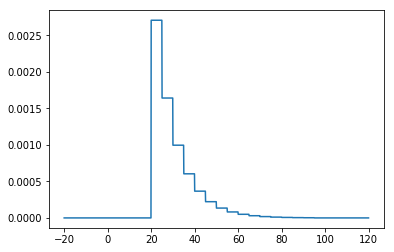

In [3]:
tbins = np.arange(20, 100, 5)
coefs = .2/10. * np.exp(-tbins[:-1]/10.)
ker = KernelRect(tbins, coefs)

t = np.arange(-20., 120., .1)
y = ker.interpolate(t)
fig, ax = plt.subplots()
ax.plot(t, y, '-')

interpolate vs interpolate sorted
- if t is sorted it can be used for efficiency

830 µs ± 46.6 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
1.25 ms ± 134 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
True


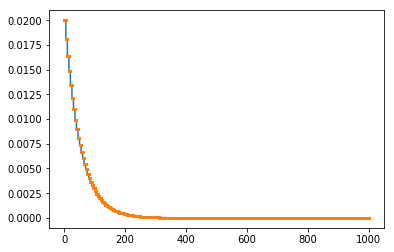

In [4]:
tbins = np.arange(0, 455, 5) # interpolation
coefs = .2/10. * np.exp(-tbins[:-1]/50)
ker = KernelRect(tbins, coefs)

t = np.arange(0, 1000, .1)
t_shuffle = np.random.choice(t, size=len(t))

%timeit -r3 -n3 ker.interpolate(t)
%timeit -r3 -n3 ker.interpolate(t, sorted_t=False)
y = ker.interpolate(t)
y2 = ker.interpolate(t, sorted_t=False)
print(np.all(y == y2))

fig, ax = plt.subplots()
ax.plot(t, y)
ax.plot(t, y2, 'o', ms=2)

# convolve_continuous <a name="convolve_continuous"></a>

Kernel method. Given a 1d-array t and an nd-array I with I.shape=(len(t),...) returns conv, the convolution of the kernel with axis 0 of I for all other axis values so that conv.shape = I.shape

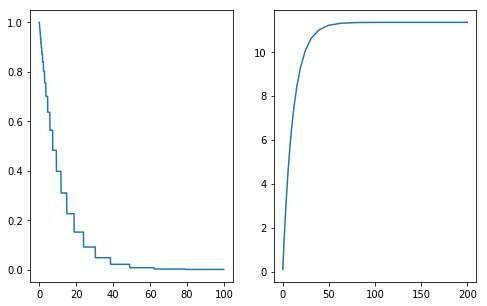

In [18]:
tbins = np.append(0, np.logspace(-1, 2, 30) )
coefs = np.exp(-tbins[:-1]/10.)
ker = KernelRect(tbins, coefs)
t = np.arange(0, 200, .1)

I = np.ones((len(t)))

conv = ker.convolve_continuous(t, I)
fig,(ax1, ax2) = plt.subplots(figsize = (8, 5), ncols = 2)

ker.plot(np.arange(0., tbins[-1], .1), ax = ax1)
ax2.plot(t, conv)

In [19]:
from icglm.utils.time import get_dt

def convolve_continuous_as_dot(self, t, I):
    
    dt = get_dt(t)
    argf = int(np.ceil(self.support[1] / dt))
    t_support = np.arange(0, argf, 1) * dt
    kernel_values = self.interpolate(t_support)
    
    design_matrix = np.zeros(I.shape[1:] + (len(t), argf))
    for arg in range(argf):
        design_matrix[..., arg:, arg] = I[:len(t) - arg].T
        
    conv = (design_matrix @ kernel_values).T * dt
    
    return conv

def convolve_continuous_as_dot_from_design_matrix(self, t, design_matrix):
    
    dt = get_dt(t)
    argf = int(np.ceil(self.support[1] / dt))
    t_support = np.arange(0, argf, 1) * dt
    kernel_values = self.interpolate(t_support)
        
    conv = (design_matrix @ kernel_values).T * dt
    
    return conv

KernelRect.convolve_continuous_as_dot = convolve_continuous_as_dot
KernelRect.convolve_continuous_as_dot_from_design_matrix = convolve_continuous_as_dot_from_design_matrix

tbins = np.arange(0, 362, 8)
coefs = np.exp(-tbins[:-1] / 10)
ker = KernelRect(tbins, coefs)
dt = .5
t = np.arange(0, 10000, dt)

I = np.random.randn(len(t), 2)
argf = int(np.ceil(ker.support[1] / dt))
design_matrix = np.zeros(I.shape[1:] + (len(t), argf))
for arg in range(argf):
    design_matrix[..., arg:, arg] = I[:len(t) - arg].T

conv = ker.convolve_continuous(t, I)
conv_dot = ker.convolve_continuous_as_dot(t, I)
conv_dot2 = ker.convolve_continuous_as_dot_from_design_matrix(t, design_matrix)

%timeit -n1 -r3 ker.convolve_continuous(t, I)
%timeit -n1 -r3 ker.convolve_continuous_as_dot(t, I)
%timeit -n1 -r3 ker.convolve_continuous_as_dot_from_design_matrix(t, design_matrix)

print(np.allclose(conv, conv_dot))

fig, ax = plt.subplots(figsize = (10, 5), ncols=1)
ax.plot(t, conv)
ax.plot(t, conv_dot)

ModuleNotFoundError: No module named 'icglm'

# interpolate_basis <a name="interpolate_basis"></a>

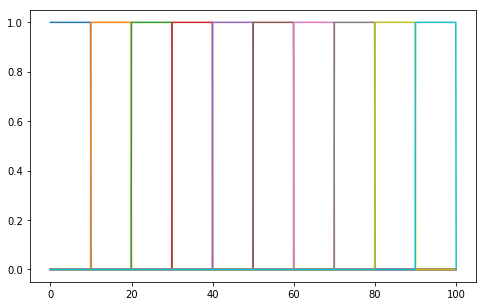

In [10]:
tbins = np.arange(0, 110, 10)
coefs = np.exp(-tbins[:-1] / 10)
ker = KernelRect(tbins, coefs=coefs)

t = np.arange(0, 100, .1)
# signal = np.zeros(len(t))
# signal[500:501] = 1

X = ker.interpolate_basis(t)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(t, X);

In [11]:
ker.support

array([  0, 100])

In [8]:
t[-1]

99.9

In [9]:
tbins[-1]

100

# convolve_basis_continuous <a name="convolve_basis_continuous"></a>

[  0 100 200 300 400 500 600 700 800 900] 900


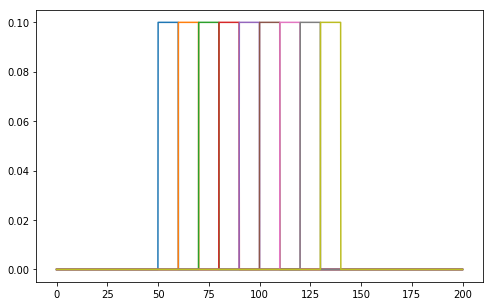

In [4]:
#tbins = np.append(0, np.logspace(-1, 2, 10) )
tbins = np.arange(0, 100, 10)
# coefs = np.exp(-tbins[:-1] / 10)
ker = KernelRect(tbins, coefs=coefs)

t = np.arange(0, 200, .1)
signal = np.zeros(len(t))
signal[500:501] = 1

X = ker.convolve_basis_continuous(t, signal)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(t, X);

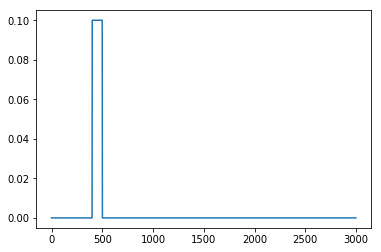

In [65]:
plt.figure()
plt.plot(X[:, 4])

[  0 100 200 300 400] 401


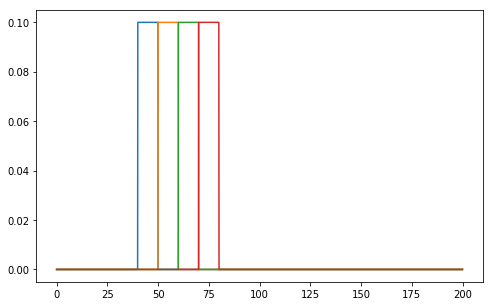

In [12]:
#tbins = np.append(0, np.logspace(-1, 2, 10) )
# tbins = np.arange(-50, 70, 10)
tbins = np.arange(0, 50, 10) - 60
# coefs = np.exp(-tbins[:-1] / 10)
ker = KernelRect(tbins, coefs=coefs)

t = np.arange(0, 200, .1)
signal = np.zeros(len(t))
signal[1000:1001] = 1

X = ker.convolve_basis_continuous(t, signal)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(t, X);

[   0  100  200  300  400  500  600  700  800  900 1000]


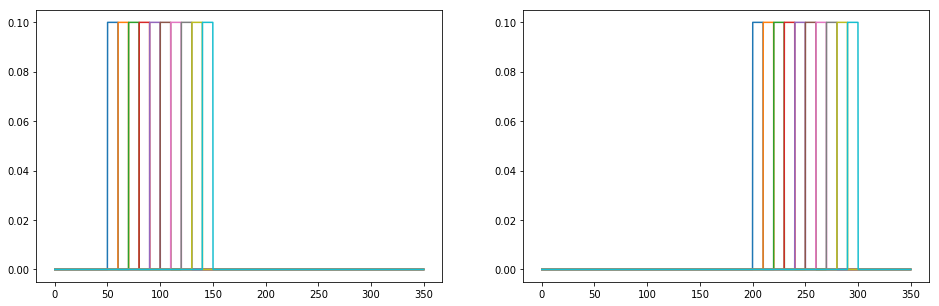

In [21]:
#tbins = np.append(0, np.logspace(-1, 2, 10) )
tbins = np.arange(0, 110, 10)
# coefs = np.exp(-tbins[:-1] / 10)
ker = KernelRect(tbins, coefs=coefs)

t = np.arange(0, 350, .1)
signal = np.zeros((len(t), 2))
signal[500:501, 0] = 1
signal[2000:2001, 1] = 1

X = ker.convolve_basis_continuous(t, signal)

fig, (ax1, ax2) = plt.subplots(figsize=(16, 5), ncols=2)
ax1.plot(t, X[:, 0]);
ax2.plot(t, X[:, 1]);

[  0 100 200 300 400 500 600 700 800 900]


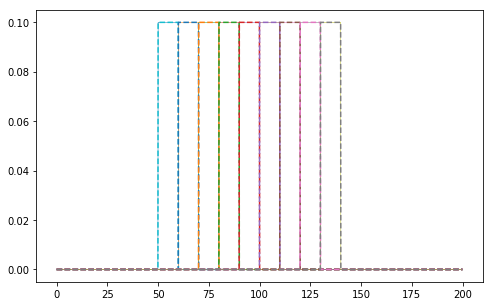

In [22]:
#tbins = np.append(0, np.logspace(-1, 2, 10) )
tbins = np.arange(0, 100, 10)
# coefs = np.exp(-tbins[:-1] / 10)
ker = KernelRect(tbins, coefs=coefs)

t = np.arange(0, 200, .1)
signal = np.zeros(len(t))
signal[500:501] = 1

X = ker.convolve_basis_continuous(t, signal)

X2 = np.zeros(signal.shape + (len(tbins) -1, ))

for k in range(X2.shape[1]):
    X2[:, k] = KernelRect([tbins[k], tbins[k + 1]], coefs=[1]).convolve_continuous(t, signal)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(t, X, lw=.5);
ax.plot(t, X2, '--');

# deconvolve_continuous <a name="deconvolve_continuous"></a>

[  0 100 200 300 400 500 600 700 800 900] 901


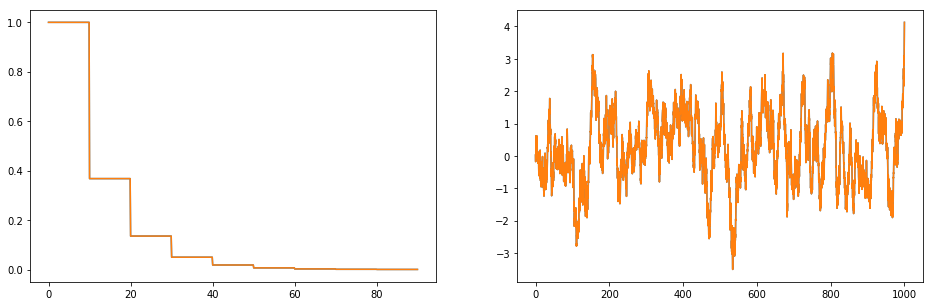

In [13]:
tau = 10
tbins = np.arange(0., 100, 10)
coefs = np.exp(-tbins[:-1] / tau)
ker_true = KernelRect(tbins, coefs)

dt = .1
t = np.arange(0, 1000, dt)
signal = np.random.randn(len(t))

conv = ker_true.convolve_continuous(t, signal)

ker = KernelRect(tbins)
ker.deconvolve_continuous(t, signal, conv)

# print(np.allclose(kerf.convolve_continuous(t, I), ker.convolve_continuous(t, I)))

fig,(ax1, ax2) = plt.subplots(figsize=(16, 5), ncols=2)

ker_true.plot(np.arange(0., tbins[-1], .1), ax = ax1)
ker.plot(np.arange(0., tbins[-1], .1), ax = ax1)
ax2.plot(t, conv)
ax2.plot(t, ker.convolve_continuous(t, signal))

holi
[  0 100 200 300 400 500 600 700 800 900]


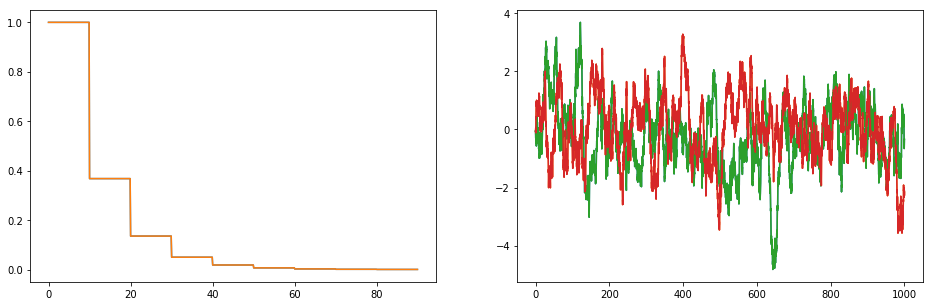

In [8]:
tau = 10
tbins = np.arange(0., 100, 10)
coefs = np.exp(-tbins[:-1] / tau)
ker_true = KernelRect(tbins, coefs)

dt = .1
t = np.arange(0, 1000, dt)
signal = np.random.randn(len(t), 2)

conv = ker_true.convolve_continuous(t, signal)

ker = KernelRect(tbins)
ker.deconvolve_continuous(t, signal, conv)

# print(np.allclose(kerf.convolve_continuous(t, I), ker.convolve_continuous(t, I)))

fig,(ax1, ax2) = plt.subplots(figsize=(16, 5), ncols=2)

ker_true.plot(np.arange(0., tbins[-1], .1), ax = ax1)
ker.plot(np.arange(0., tbins[-1], .1), ax = ax1)
ax2.plot(t, conv)
ax2.plot(t, ker.convolve_continuous(t, signal))

[   0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300
 1400 1500 1600 1700 1800 1900 2000] 2001
True


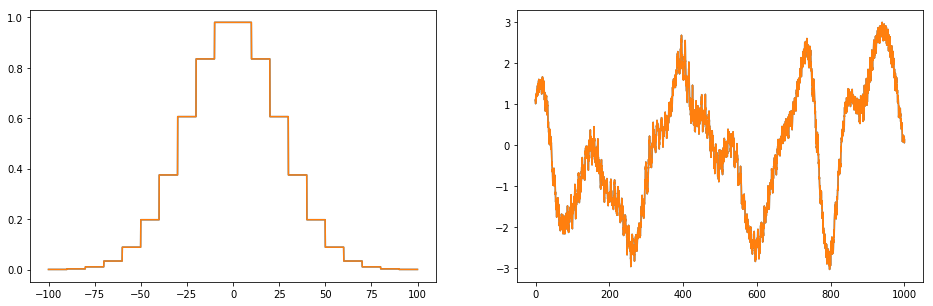

In [33]:
tau = 50
tbins = np.arange(-100, 110, 10)
# coefs = np.exp(-(tbins[:-1] + tbins[1:]) / 2 / tau)
coefs = np.exp(-(tbins[:-1] + tbins[1:] - tbins[len(tbins) // 2])**2 / 2 / tau**2)
ker_true = KernelRect(tbins, coefs)

dt = .1
t = np.arange(0, 1000, dt)
signal = np.random.randn(len(t))

conv = ker_true.convolve_continuous(t, signal)

ker = KernelRect(tbins)
ker.deconvolve_continuous(t, signal + np.random.rand(*signal.shape) * .0, conv)

print(np.allclose(ker_true.convolve_continuous(t, signal), ker.convolve_continuous(t, signal)))

fig,(ax1, ax2) = plt.subplots(figsize=(16, 5), ncols=2)

ker_true.plot(np.arange(tbins[0], tbins[-1], .1), ax = ax1)
ker.plot(np.arange(tbins[0], tbins[-1], .1), ax = ax1)
ax2.plot(t, conv)
ax2.plot(t, ker.convolve_continuous(t, signal))

# convolve_discrete <a name="convolve_discrete"></a>

[1.]
(1000,)
0.0


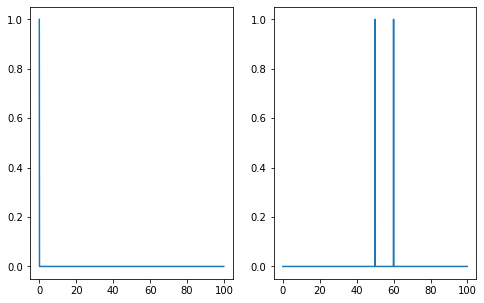

In [10]:
tbins = np.append(0, np.logspace(-1, 2, 30) )
coefs = np.exp(-tbins[:-1]/10.)
#ker = KernelRect(tbins, coefs)
ker = KernelRect([0., .1], [1.])
print(ker.interpolate([0.]))
t = np.arange(0, 100, .1)

tj = np.array([50., 60.])
#tj = np.array([0., 21.5, 30.8, 30.9, 50., 55., 60., 75.1, 88.4, 99.9])
#tj = (np.array([5., 15., 50., 60., 70., 80., 99.9]), np.array([0, 0, 1, 1, 2, 2, 2]) )

conv = ker.convolve_discrete(t, tj)
print(conv.shape)
print(conv[-1])
fig,(ax1, ax2) = plt.subplots(figsize = (8, 5), ncols = 2)

ker.plot(np.arange(0., tbins[-1], .1), ax = ax1)
ax2.plot(t, conv)

True


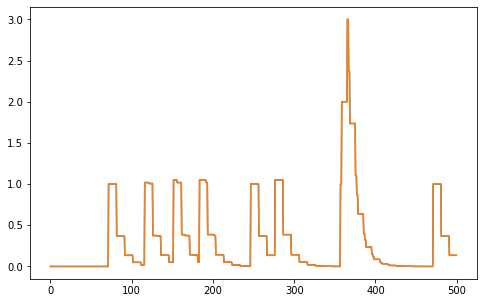

In [20]:
tbins = np.arange(0, 100, 10)
coefs = np.exp(-tbins[:-1] / 10)
ker = KernelRect(tbins, coefs)

dt = .5
t = np.arange(0, 500, dt)
argj = np.sort(np.random.choice(len(t), size=10))
tj = t[argj]
signal = np.zeros(len(t))
signal[argj] = 1 / dt

conv_cont = ker.convolve_continuous(t, signal)
conv_disc = ker.convolve_discrete(t, tj)
print(np.allclose(conv_disc, conv_cont))

fig,ax = plt.subplots(figsize=(8, 5))
ax.plot(t, conv_cont)
ax.plot(t, conv_disc)

(2000, 2, 2)


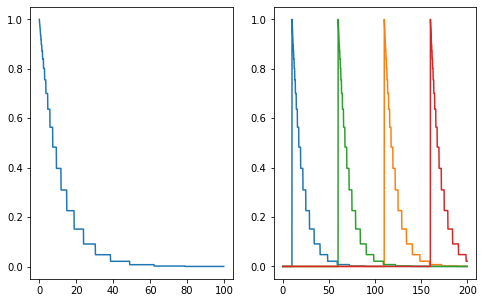

In [21]:
tbins = np.append(0, np.logspace(-1, 2, 30) )
coefs = np.exp(-tbins[:-1]/10.)
ker = KernelRect(tbins, coefs)
t = np.arange(0, 200, .1)

tj = (np.array([10., 60., 110., 160.]), np.array([0, 0, 1, 1]), np.array([0, 1, 0, 1]) )

conv = ker.convolve_discrete(t, tj)
print(conv.shape)

fig,(ax1, ax2) = plt.subplots(figsize = (8, 5), ncols = 2)

ker.plot(np.arange(0., tbins[-1], .1), ax = ax1)
ax2.plot(t, conv[:,:,0])
ax2.plot(t, conv[:,:,1])

# convolve_basis_discrete

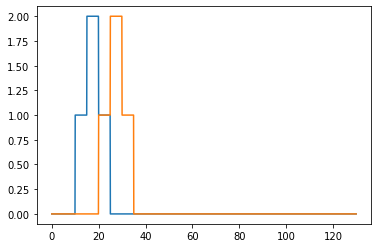

In [22]:
t = np.arange(0., 130., .1)
tj = np.array([10., 15.])
#tjs = np.array([10.])

tbins = np.arange(0., 30, 10.)
ker = KernelRect(tbins)

X = ker.convolve_basis_discrete(t, tj)

plt.figure()
plt.plot(t, X)

[2]
(1300, 2, 2)


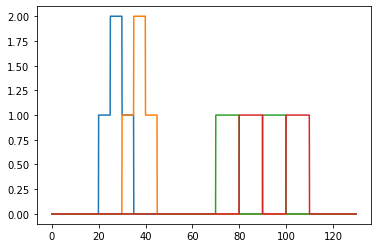

In [23]:
t = np.arange(0., 130., .1)
#tj = (np.array([20., 25., 70., 90.]), np.array([0, 0, 1, 1]) )
#tj = [np.array([20., 25., 70., 90.])]
tj = [np.array([20., 25., 70., 90.]), np.array([0, 0, 1, 1]) ]
#tjs = np.array([10.])

tbins = np.arange(0., 30, 10.)
ker = KernelRect(tbins)

X = ker.convolve_basis_discrete(t, tj)
print([max(tj[dim])+1 for dim in range(1, len(tj))])
print(X.shape)

plt.figure()
plt.plot(t, X[:,0,:])
plt.plot(t, X[:,1,:])